Version 1.0.1

# Check your versions

In [1]:
import numpy as np
import pandas as pd 
import sklearn
import scipy.sparse 
import lightgbm 

for p in [np, pd, scipy, sklearn, lightgbm]:
    print (p.__name__, p.__version__)

numpy 1.13.1
pandas 0.20.3
scipy 0.19.1
sklearn 0.19.0
lightgbm 2.0.6


**Important!** There is a huge chance that the assignment will be impossible to pass if the versions of `lighgbm` and `scikit-learn` are wrong. The versions being tested:

    numpy 1.13.1
    pandas 0.20.3
    scipy 0.19.1
    sklearn 0.19.0
    ligthgbm 2.0.6
    

To install an older version of `lighgbm` you may use the following command:
```
pip uninstall lightgbm
pip install lightgbm==2.0.6
```

# Ensembling

In this programming assignment you are asked to implement two ensembling schemes: simple linear mix and stacking.

We will spend several cells to load data and create feature matrix, you can scroll down this part or try to understand what's happening.

In [2]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
%matplotlib inline 

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)

import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook

from itertools import product


def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

## Data fields
   - ID - an Id that represents a (Shop, Item) tuple within the test set
   - shop_id - unique identifier of a shop
   - item_id - unique identifier of a product
   - item_category_id - unique identifier of item category
   - item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
   - item_price - current price of an item
   - date - date in format dd/mm/yyyy
   - **date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33**
   - item_name - name of item
   - shop_name - name of shop
   - item_category_name - name of item category

# Load data subset

Let's load the data from the hard drive first.

In [3]:
sales = pd.read_csv('../readonly/final_project_data/sales_train.csv.gz')
shops = pd.read_csv('../readonly/final_project_data/shops.csv')
items = pd.read_csv('../readonly/final_project_data/items.csv')
item_cats = pd.read_csv('../readonly/final_project_data/item_categories.csv')

And use only 3 shops for simplicity.

In [4]:
sales = sales[sales['shop_id'].isin([26, 27, 28])]

In [11]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [12]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [13]:
item_cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [14]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
15036,05.01.2013,0,28,7738,199.0,1.0
15037,07.01.2013,0,28,7738,199.0,1.0
15038,19.01.2013,0,28,7738,199.0,1.0
15039,03.01.2013,0,28,7737,199.0,1.0
15040,04.01.2013,0,28,7737,199.0,1.0


In [17]:
m = sales[sales['date_block_num'] == 1]
m

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
203785,27.02.2013,1,26,16409,149.00,1.0
203786,13.02.2013,1,26,16755,700.00,1.0
203787,02.02.2013,1,26,16450,399.00,3.0
203788,09.02.2013,1,26,16450,399.00,1.0
203789,10.02.2013,1,26,16450,399.00,1.0
203790,22.02.2013,1,26,16450,399.00,1.0
203791,02.02.2013,1,26,16451,499.00,-1.0
203792,02.02.2013,1,26,16409,149.00,1.0
203793,04.02.2013,1,26,16451,499.00,1.0
203794,08.02.2013,1,26,16471,149.00,1.0


# Get a feature matrix

We now need to prepare the features. This part is all implemented for you.

In [5]:
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

# Groupby data to get shop-item-month aggregates
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})
# Fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
# Join it to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

# Same as above but with shop-month aggregates
gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop':'sum'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates
gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item':'sum'}})
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
del grid, gb 
gc.collect();

/opt/conda/lib/python3.6/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


## Step by step process to prepare the feature
## Start 1.1

In [53]:
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']


In [54]:
f = sales['date_block_num'].unique()
f

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

In [55]:
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()


In [56]:
cur_shops

array([28, 26])

In [57]:
for block_num in sales['date_block_num'].unique():
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    
cur_items

array([ 3352,  3353,  3479, ..., 21976, 21881, 21914])

In [58]:
type(cur_items)

numpy.ndarray

In [59]:
# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

In [60]:
grid

[array([[  28, 7738,    0],
        [  28, 7737,    0],
        [  28, 7770,    0],
        ..., 
        [  26, 6397,    0],
        [  26, 6405,    0],
        [  26, 6510,    0]], dtype=int32), array([[   26, 16409,     1],
        [   26, 16755,     1],
        [   26, 16450,     1],
        ..., 
        [   28, 13433,     1],
        [   28, 13435,     1],
        [   28, 13495,     1]], dtype=int32), array([[  28, 4496,    2],
        [  28, 4446,    2],
        [  28, 4485,    2],
        ..., 
        [  26,   68,    2],
        [  26,   43,    2],
        [  26,   34,    2]], dtype=int32), array([[  28, 3903,    3],
        [  28, 3738,    3],
        [  28, 3739,    3],
        ..., 
        [  26, 3624,    3],
        [  26, 3850,    3],
        [  26, 3718,    3]], dtype=int32), array([[   27, 20239,     4],
        [   27, 20238,     4],
        [   27, 20785,     4],
        ..., 
        [   26,    42,     4],
        [   26,    41,     4],
        [   26,    40,     4]

In [61]:
# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)
grid

,shop_id,item_id,date_block_num
0,28,7738,0
1,28,7737,0
2,28,7770,0
3,28,7664,0
4,28,7814,0
5,28,7815,0
6,28,7820,0
7,28,7672,0
8,28,7536,0
9,28,7448,0


In [62]:
# Groupby data to get shop-item-month aggregates
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})
gb.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


,shop_id,item_id,date_block_num,item_cnt_day
,,,,target
0,26,27,0,1.0
1,26,27,10,1.0
2,26,27,14,1.0
3,26,28,8,1.0
4,26,28,9,1.0


In [41]:
#get aggregated values for (shop_id, item_id, month)
gb = sales.groupby(index_cols,as_index=False).aggregate({"item_cnt_day":['sum']})
gb.head()

,shop_id,item_id,date_block_num,item_cnt_day
,,,,sum
0,26,27,0,1.0
1,26,27,10,1.0
2,26,27,14,1.0
3,26,28,8,1.0
4,26,28,9,1.0


In [42]:
#fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
gb.head()

,shop_id,item_id,date_block_num,sum
0,26,27,0,1.0
1,26,27,10,1.0
2,26,27,14,1.0
3,26,28,8,1.0
4,26,28,9,1.0


In [63]:
#fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
gb.head()

,shop_id,item_id,date_block_num,target
0,26,27,0,1.0
1,26,27,10,1.0
2,26,27,14,1.0
3,26,28,8,1.0
4,26,28,9,1.0


In [64]:
# Join it to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)
all_data.head()

,shop_id,item_id,date_block_num,target
0,28,7738,0,4.0
1,28,7737,0,10.0
2,28,7770,0,6.0
3,28,7664,0,1.0
4,28,7814,0,2.0


In [65]:
# Same as above but with shop-month aggregates
gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop':'sum'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)
all_data

/opt/conda/lib/python3.6/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


,shop_id,item_id,date_block_num,target,target_shop
0,28,7738,0,4.0,7057.0
1,28,7737,0,10.0,7057.0
2,28,7770,0,6.0,7057.0
3,28,7664,0,1.0,7057.0
4,28,7814,0,2.0,7057.0
5,28,7815,0,2.0,7057.0
6,28,7820,0,4.0,7057.0
7,28,7672,0,1.0,7057.0
8,28,7536,0,9.0,7057.0
9,28,7448,0,7.0,7057.0


In [66]:
# Same as above but with item-month aggregates
gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item':'sum'}})
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)
all_data.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


,shop_id,item_id,date_block_num,target,target_shop,target_item
0,28,7738,0,4.0,7057.0,11.0
1,28,7737,0,10.0,7057.0,16.0
2,28,7770,0,6.0,7057.0,10.0
3,28,7664,0,1.0,7057.0,1.0
4,28,7814,0,2.0,7057.0,6.0


In [67]:
# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
del grid, gb 
gc.collect();

## End 1.1

After creating a grid, we can calculate some features. We will use lags from [1, 2, 3, 4, 5, 12] months ago.

In [6]:
# List of columns that we will use to create lags
cols_to_rename = list(all_data.columns.difference(index_cols)) 

shift_range = [1, 2, 3, 4, 5, 12]

for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

del train_shift

# Don't use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= 12] 

# List of all lagged features
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 
# We will drop these at fitting stage
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 

# Category for each item
item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()

all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
all_data = downcast_dtypes(all_data)
gc.collect();

A Jupyter Widget

## Step by step process to Calculate some feature 
## Start 1.2

In [6]:
f = all_data.columns
f

Index(['shop_id', 'item_id', 'date_block_num', 'target', 'target_shop',
       'target_item'],
      dtype='object')

In [7]:
index_cols

['shop_id', 'item_id', 'date_block_num']

In [8]:
# List of columns that we will use to create lags
cols_to_rename = list(all_data.columns.difference(index_cols)) 
cols_to_rename

['target', 'target_item', 'target_shop']

In [10]:
shift_range = [1, 2, 3, 4, 5, 12]

for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()

train_shift

A Jupyter Widget

,shop_id,item_id,date_block_num,target,target_item,target_shop
0,28,7738,0,4.0,11.0,7057.0
1,28,7737,0,10.0,16.0,7057.0
2,28,7770,0,6.0,10.0,7057.0
3,28,7664,0,1.0,1.0,7057.0
4,28,7814,0,2.0,6.0,7057.0
5,28,7815,0,2.0,6.0,7057.0
6,28,7820,0,4.0,23.0,7057.0
7,28,7672,0,1.0,2.0,7057.0
8,28,7536,0,9.0,15.0,7057.0
9,28,7448,0,7.0,18.0,7057.0


In [11]:
shift_range = [1, 2, 3, 4, 5, 12]

for month_shift in tqdm_notebook(shift_range):
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
train_shift

A Jupyter Widget

,shop_id,item_id,date_block_num,target,target_item,target_shop
0,28,7738,27,4.0,11.0,7057.0
1,28,7737,27,10.0,16.0,7057.0
2,28,7770,27,6.0,10.0,7057.0
3,28,7664,27,1.0,1.0,7057.0
4,28,7814,27,2.0,6.0,7057.0
5,28,7815,27,2.0,6.0,7057.0
6,28,7820,27,4.0,23.0,7057.0
7,28,7672,27,1.0,2.0,7057.0
8,28,7536,27,9.0,15.0,7057.0
9,28,7448,27,7.0,18.0,7057.0


In [12]:
for month_shift in tqdm_notebook(shift_range):
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)
    
train_shift

A Jupyter Widget

,shop_id,item_id,date_block_num,target_lag_1,target_item_lag_1,target_shop_lag_1
0,28,7738,27,4.0,11.0,7057.0
1,28,7737,27,10.0,16.0,7057.0
2,28,7770,27,6.0,10.0,7057.0
3,28,7664,27,1.0,1.0,7057.0
4,28,7814,27,2.0,6.0,7057.0
5,28,7815,27,2.0,6.0,7057.0
6,28,7820,27,4.0,23.0,7057.0
7,28,7672,27,1.0,2.0,7057.0
8,28,7536,27,9.0,15.0,7057.0
9,28,7448,27,7.0,18.0,7057.0


In [13]:
for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)
    
train_shift

A Jupyter Widget

,shop_id,item_id,date_block_num,target_lag_12,target_item_lag_12,target_shop_lag_12
0,28,7738,12,4.0,11.0,7057.0
1,28,7737,12,10.0,16.0,7057.0
2,28,7770,12,6.0,10.0,7057.0
3,28,7664,12,1.0,1.0,7057.0
4,28,7814,12,2.0,6.0,7057.0
5,28,7815,12,2.0,6.0,7057.0
6,28,7820,12,4.0,23.0,7057.0
7,28,7672,12,1.0,2.0,7057.0
8,28,7536,12,9.0,15.0,7057.0
9,28,7448,12,7.0,18.0,7057.0


In [14]:
shift_range = [1, 2, 3, 4, 5, 12]

for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

del train_shift


A Jupyter Widget

In [15]:
# Don't use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= 12] 
all_data.head()


,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12
120669,28,10994,12,1.0,6949.0,1.0,0.0,1.0,8499.0,0.0,1.0,6454.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
120670,28,10992,12,3.0,6949.0,4.0,3.0,7.0,8499.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7521.0,0.0,0.0,0.0
120671,28,10991,12,1.0,6949.0,5.0,1.0,3.0,8499.0,0.0,0.0,0.0,0.0,1.0,5609.0,0.0,2.0,6753.0,2.0,4.0,7521.0,0.0,0.0,0.0
120672,28,10988,12,1.0,6949.0,2.0,2.0,5.0,8499.0,4.0,5.0,6454.0,5.0,6.0,5609.0,0.0,2.0,6753.0,0.0,0.0,0.0,0.0,0.0,0.0
120673,28,11002,12,1.0,6949.0,1.0,0.0,1.0,8499.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# List of all lagged features
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 
fit_cols

['target_lag_1',
 'target_item_lag_1',
 'target_shop_lag_1',
 'target_lag_2',
 'target_item_lag_2',
 'target_shop_lag_2',
 'target_lag_3',
 'target_item_lag_3',
 'target_shop_lag_3',
 'target_lag_4',
 'target_item_lag_4',
 'target_shop_lag_4',
 'target_lag_5',
 'target_item_lag_5',
 'target_shop_lag_5',
 'target_lag_12',
 'target_item_lag_12',
 'target_shop_lag_12']

In [18]:
# We will drop these at fitting stage
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 
to_drop_cols


['target_shop', 'target', 'target_item', 'date_block_num']

In [19]:
# Category for each item
item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()

item_category_mapping

,item_id,item_category_id
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40
5,5,40
6,6,40
7,7,40
8,8,40
9,9,40


In [20]:
all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
all_data = downcast_dtypes(all_data)
gc.collect();

## End 1.2

To this end, we've created a feature matrix. It is stored in `all_data` variable. Take a look:

In [11]:
all_data.head(5)

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id
0,28,10994,12,1.0,6949.0,1.0,0.0,1.0,8499.0,0.0,1.0,6454.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
1,28,10992,12,3.0,6949.0,4.0,3.0,7.0,8499.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7521.0,0.0,0.0,0.0,37
2,28,10991,12,1.0,6949.0,5.0,1.0,3.0,8499.0,0.0,0.0,0.0,0.0,1.0,5609.0,0.0,2.0,6753.0,2.0,4.0,7521.0,0.0,0.0,0.0,40
3,28,10988,12,1.0,6949.0,2.0,2.0,5.0,8499.0,4.0,5.0,6454.0,5.0,6.0,5609.0,0.0,2.0,6753.0,0.0,0.0,0.0,0.0,0.0,0.0,40
4,28,11002,12,1.0,6949.0,1.0,0.0,1.0,8499.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40


# Train/test split

For a sake of the programming assignment, let's artificially split the data into train and test. We will treat last month data as the test set.

In [12]:
# Save `date_block_num`, as we can't use them as features, but will need them to split the dataset into parts 
dates = all_data['date_block_num']

last_block = dates.max()
print('Test `date_block_num` is %d' % last_block)

Test `date_block_num` is 33


In [13]:
dates_train = dates[dates <  last_block]
dates_test  = dates[dates == last_block]

X_train = all_data.loc[dates <  last_block].drop(to_drop_cols, axis=1)
X_test =  all_data.loc[dates == last_block].drop(to_drop_cols, axis=1)

y_train = all_data.loc[dates <  last_block, 'target'].values
y_test =  all_data.loc[dates == last_block, 'target'].values

# First level models 

You need to implement a basic stacking scheme. We have a time component here, so we will use ***scheme f)*** from the reading material. Recall, that we always use first level models to build two datasets: test meta-features and 2-nd level train-metafetures. Let's see how we get test meta-features first. 

### Test meta-features

Firts, we will run *linear regression* on numeric columns and get predictions for the last month.

In [14]:
lr = LinearRegression()
lr.fit(X_train.values, y_train)
pred_lr = lr.predict(X_test.values)

print('Test R-squared for linreg is %f' % r2_score(y_test, pred_lr))

Test R-squared for linreg is 0.743180


And the we run *LightGBM*.

In [15]:
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
pred_lgb = model.predict(X_test)

print('Test R-squared for LightGBM is %f' % r2_score(y_test, pred_lgb))

Test R-squared for LightGBM is 0.738391


Finally, concatenate test predictions to get test meta-features.

In [16]:
X_test_level2 = np.c_[pred_lr, pred_lgb] 

### Train meta-features

**Now it is your turn to write the code**. You need to implement ***scheme f)*** from the reading material. Here, we will use duration **T** equal to month and **M=15**.  

That is, you need to get predictions (meta-features) from *linear regression* and *LightGBM* for months 27, 28, 29, 30, 31, 32. Use the same parameters as in above models.

In [17]:
dates_train_level2 = dates_train[dates_train.isin([27, 28, 29, 30, 31, 32])]

# That is how we get target for the 2nd level dataset
y_train_level2 = y_train[dates_train.isin([27, 28, 29, 30, 31, 32])]

In [19]:
# And here we create 2nd level feeature matrix, init it with zeros first
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])

# Now fill `X_train_level2` with metafeatures
for cur_block_num in [27, 28, 29, 30, 31, 32]:
    
    print(cur_block_num)
    
    '''
        1. Split `X_train` into parts
           Remember, that corresponding dates are stored in `dates_train` 
        2. Fit linear regression 
        3. Fit LightGBM and put predictions          
        4. Store predictions from 2. and 3. in the right place of `X_train_level2`. 
           You can use `dates_train_level2` for it
           Make sure the order of the meta-features is the same as in `X_test_level2`
    '''      
    
    #  YOUR CODE GOES HERE
    X_train = all_data.loc[dates <  cur_block_num].drop(to_drop_cols, axis=1)
    X_test =  all_data.loc[dates == cur_block_num].drop(to_drop_cols, axis=1)
    
    y_train = all_data.loc[dates <  cur_block_num, 'target'].values
    
    
    lr.fit(X_train.values, y_train)
    pred_lr = lr.predict(X_test.values)
    model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
    pred_lgb = model.predict(X_test)
    
    indexes = dates_train_level2.index[dates_train_level2 == cur_block_num]
    
    for i in range(pred_lgb.shape[0]):
        X_train_level2[indexes[i] - 120192 ] = [pred_lr[i], pred_lgb[i]]
    
    
# Sanity check
assert np.all(np.isclose(X_train_level2.mean(axis=0), [ 1.50148988,  1.38811989]))

27
28
29
30
31
32


Remember, the ensembles work best, when first level models are diverse. We can qualitatively analyze the diversity by examinig *scatter plot* between the two metafeatures. Plot the scatter plot below. 

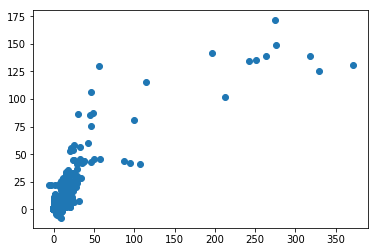

In [20]:
# YOUR CODE GOES HERE
x = X_train_level2[:,0]
y = X_train_level2[:,1]
plt.scatter(x, y)
plt.show()

# Ensembling

Now, when the meta-features are created, we can ensemble our first level models.

### Simple convex mix

Let's start with simple linear convex mix:

$$
mix= \alpha\cdot\text{linreg_prediction}+(1-\alpha)\cdot\text{lgb_prediction}
$$

We need to find an optimal $\alpha$. And it is very easy, as it is feasible to do grid search. Next, find the optimal $\alpha$ out of `alphas_to_try` array. Remember, that you need to use train meta-features (not test) when searching for $\alpha$. 

In [21]:
alphas_to_try = np.linspace(0, 1, 1001)

# YOUR CODE GOES HERE
best_alpha = -1
r2_train_simple_mix = -1

for current_alpha in alphas_to_try:
    mix = current_alpha * X_train_level2[:,0] + (1 - current_alpha) * X_train_level2[:,1]
    current_r2 = r2_score(y_train_level2, mix)
    if(current_r2 > r2_train_simple_mix):
        r2_train_simple_mix = current_r2
        best_alpha = current_alpha

print('Best alpha: %f; Corresponding r2 score on train: %f' % (best_alpha, r2_train_simple_mix))

Best alpha: 0.765000; Corresponding r2 score on train: 0.627255


Now use the $\alpha$ you've found to compute predictions for the test set 

In [22]:
test_preds = best_alpha * X_test_level2[:,0] + (1 - best_alpha) * X_test_level2[:,1]
r2_test_simple_mix = r2_score(y_test, test_preds)

print('Test R-squared for simple mix is %f' % r2_test_simple_mix)

Test R-squared for simple mix is 0.781144


### Stacking

Now, we will try a more advanced ensembling technique. Fit a linear regression model to the meta-features. Use the same parameters as in the model above.

In [23]:
# YOUR CODE GOES HERE
lr.fit(X_train_level2, y_train_level2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Compute R-squared on the train and test sets.

In [24]:
train_preds = lr.predict(X_train_level2)
r2_train_stacking = r2_score(y_train_level2, train_preds)

test_preds = lr.predict(X_test_level2)
r2_test_stacking = r2_score(y_test, test_preds)

print('Train R-squared for stacking is %f' % r2_train_stacking)
print('Test  R-squared for stacking is %f' % r2_test_stacking)

Train R-squared for stacking is 0.632176
Test  R-squared for stacking is 0.771297


Interesting, that the score turned out to be lower than in previous method. Although the model is very simple (just 3 parameters) and, in fact, mixes predictions linearly, it looks like it managed to overfit. **Examine and compare** train and test scores for the two methods. 

And of course this particular case does not mean simple mix is always better than stacking.

We all done! Submit everything we need to the grader now.

In [25]:
from grader import Grader
grader = Grader()

grader.submit_tag('best_alpha', best_alpha)

grader.submit_tag('r2_train_simple_mix', r2_train_simple_mix)
grader.submit_tag('r2_test_simple_mix',  r2_test_simple_mix)

grader.submit_tag('r2_train_stacking', r2_train_stacking)
grader.submit_tag('r2_test_stacking',  r2_test_stacking)

Current answer for task best_alpha is: 0.765
Current answer for task r2_train_simple_mix is: 0.627255043446
Current answer for task r2_test_simple_mix is: 0.781144169579
Current answer for task r2_train_stacking is: 0.632175561459
Current answer for task r2_test_stacking is: 0.771297132342


In [ ]:
STUDENT_EMAIL = # EMAIL HERE
STUDENT_TOKEN = # TOKEN HERE
grader.status()

In [ ]:
grader.submit(STUDENT_EMAIL, STUDENT_TOKEN)